Make sure the tf version is 2.5.0-dev20201111 or later (for model saving)

In [1]:
#!pip install tf-nightly==2.5.0.dev20201111 -qqq --progress-bar off
import tensorflow as tf
print(tf.__version__)
assert tf.__version__== '2.5.0-dev20201111','bad version'

2.5.0-dev20201111


In [4]:
#!pip uninstall tf-nightly

In [2]:
# from google.colab import drive
# drive.mount("/content/drive")
# print('done, mounted')
# #print(now())

In [3]:
cd /Users/aidasaglinskas/Desktop/BC-MRI-AE/

/Users/aidasaglinskas/Desktop/BC-MRI-AE


In [4]:
#cd /content/drive/My Drive/BC-MRI-AE/

In [5]:
cd 'Colab Notebooks'

/Users/aidasaglinskas/Desktop/BC-MRI-AE/Colab Notebooks


In [6]:
%matplotlib inline
from datetime import datetime;now = datetime.now;t00 = now()
import os
from matplotlib import pyplot as plt
import seaborn as sns

import numpy as np
import pandas as pd
from tqdm import tqdm

#from contrastive_vae.celeb_utils import get_celeb_vae
#from contrastive_vae.celeb_utils import get_celeb_cvae

import pandas as pd
from sklearn.metrics import silhouette_score

from mri_utils import get_MRI_CVAE_3D,get_MRI_CCVAE_3D

print(now()-t00)

0:00:00.569080


In [7]:
cd ../

/Users/aidasaglinskas/Desktop/BC-MRI-AE


SHAPE THE DATA

In [8]:
arr = np.load('./Data/ABIDE-Anat-64iso.npz')
ABIDE_data = arr['data']
ABIDE_subs = arr['subs']
nsubs = ABIDE_data.shape[0]
[arr.shape for arr in [ABIDE_subs,ABIDE_data]]

[(1022,), (1022, 64, 64, 64)]

In [9]:
aa = np.array([ABIDE_data[s,:,:,:].sum() for s in range(ABIDE_data.shape[0])])<5000
ABIDE_data = ABIDE_data[~aa,:,:,:]
ABIDE_subs = ABIDE_subs[~aa]
[arr.shape for arr in [ABIDE_subs,ABIDE_data]]

[(982,), (982, 64, 64, 64)]

In [10]:
df = pd.read_csv('./CSVs/ABIDE-legend.csv',header=1)
df = df.iloc[np.array([df['BIDS_ID'].values[s] in ABIDE_subs for s in range(len(df))])]
df.reset_index(inplace=True)

assert len(df)==len(ABIDE_subs),'dif lenghts'
assert all([df['BIDS_ID'][s]==ABIDE_subs[s] for s in range(len(df))]),'mismatch between df and goodsubs'

df.head(5)

,index,BIDS_ID,ID,SUB_TYPE,VISIT,DAY_LAG,ABIDE_01,ABIDE_02,ABIDE_03,ABIDE_04,...,ABIDE_64,ABIDE_65,ABIDE_66,ABIDE_67,ABIDE_68,ABIDE_69,ABIDE_70,ABIDE_71,ABIDE_72,ABIDE_73
0,0,sub-001,A00033348,PATIENT,session_1,8,51320,1,2,31.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN,NaN
1,1,sub-002,A00033398,CONTROL,session_1,8,51373,2,0,46.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN,NaN
2,2,sub-003,A00033352,PATIENT,session_1,8,51324,1,2,52.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN,NaN
3,3,sub-004,A00033389,CONTROL,session_1,8,51364,2,0,26.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN,NaN
4,4,sub-005,A00033354,PATIENT,session_1,8,51326,1,2,42.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN,NaN


In [11]:
TD_subs = ABIDE_data[np.array(df['SUB_TYPE']=='CONTROL'),:,:,:]
DX_subs = ABIDE_data[np.array(df['SUB_TYPE']=='PATIENT'),:,:,:]

print(TD_subs.shape)
print(DX_subs.shape)

(500, 64, 64, 64)
(456, 64, 64, 64)


In [12]:
dxArr = np.ones(len(df))
dxArr[np.array(df['SUB_TYPE']=='PATIENT')]=2

In [14]:
batch_size = 32

TD_batch = TD_subs[np.random.randint(low=0,high=TD_subs.shape[0],size=batch_size),:,:,:]
DX_batch = DX_subs[np.random.randint(low=0,high=DX_subs.shape[0],size=batch_size),:,:,:]

TRAIN THE VAE

In [15]:
encoder, decoder, vae = get_MRI_CVAE_3D(input_shape=(64, 64, 64, 1), latent_dim=2, batch_size=32, disentangle=False, gamma=1)
vae.load_weights('../tf_outputs/weights/lol')

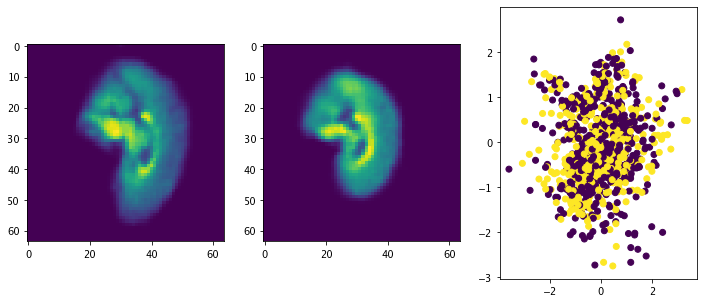

In [17]:
from scipy.spatial.distance import pdist
from scipy.spatial.distance import squareform

plt.figure(figsize=(12,5))
plt.subplot(1,3,1)
plt.imshow(vae.predict(TD_batch)[0,32,:,:,0])
plt.subplot(1,3,2)
plt.imshow(decoder.predict(np.random.randn(3,2))[0,32,:,:,0])
plt.subplot(1,3,3)
arr = encoder.predict(ABIDE_data)[2]
plt.scatter(arr[:,0],arr[:,1],c=dxArr)

In [ ]:
#encoder.save

In [ ]:
#ls '../../../My Drive/tf_outputs/3D_CCVAE_Weights/lol'

checkpoint  lol.data-00000-of-00001  lol.index


TRAIN THE CONTRASTIVE VAE

In [19]:
cvae, cvae_fg, z_encoder, s_encoder, cvae_decoder = get_MRI_CCVAE_3D()
weights_fn = '../tf_outputs/3D_CCVAE_Weights/lol'
#weights_fn = '../../../My Drive/tf_outputs/3D_CCVAE_Weights/lol'
cvae.load_weights(weights_fn)

In [ ]:
#cvae.save_weights(weights_fn)

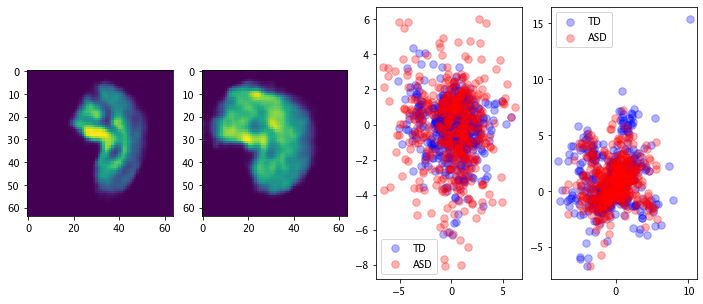

In [20]:
plt.figure(figsize=(12,5))
plt.subplot(1,4,1)

plt.imshow(cvae.predict([TD_batch,DX_batch])[0][0,32,:,:,0])
plt.subplot(1,4,2)

plt.imshow(cvae_decoder.predict(np.random.randn(3,4))[0,32,:,:,0])
plt.subplot(1,4,3)

arr = z_encoder.predict(ABIDE_data)[2]
plt.plot(arr[dxArr==1,0],arr[dxArr==1,1],'b.',markersize=15,alpha=.3)
plt.plot(arr[dxArr==2,0],arr[dxArr==2,1],'r.',markersize=15,alpha=.3)
plt.legend(['TD','ASD'])

plt.subplot(1,4,4)
arr = s_encoder.predict(ABIDE_data)[2]
plt.plot(arr[dxArr==1,0],arr[dxArr==1,1],'b.',markersize=15,alpha=.3)
plt.plot(arr[dxArr==2,0],arr[dxArr==2,1],'r.',markersize=15,alpha=.3)
plt.legend(['TD','ASD'])

In [21]:
train_CCVAE = False 

if train_CCVAE==True: 
    batch_size = 16
    n_iter = 1000
    t0 = now()
    for i in range(n_iter):
      #DX_subs,TD_subs
      history = cvae.train_on_batch([DX_subs[np.random.randint(low=0,high=DX_subs.shape[0],size=batch_size),:,:,:],TD_subs[np.random.randint(low=0,high=TD_subs.shape[0],size=batch_size),:,:,:]])

      if np.mod(i,5)==0:
        print(f"{i}/{n_iter} | loss: {history} | time elapsed: {now()-t0}")

      if all((np.mod(i,25)==0,np.isnan(history)==False)):
        cvae.save_weights(weights_fn)

([<matplotlib.axis.XTick at 0x7faac8452d10>,
 <a list of 3 Text xticklabel objects>)

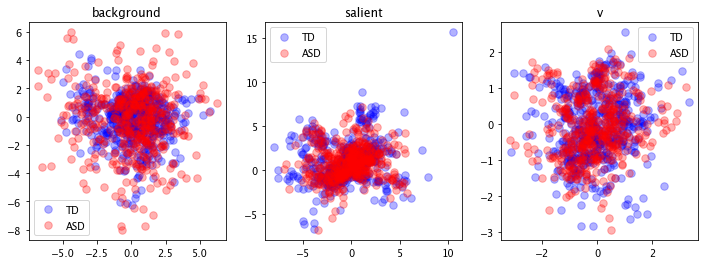

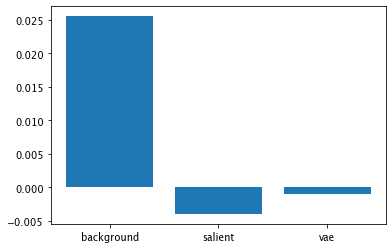

In [29]:
plt.figure(figsize=(12,4))
plt.subplot(1,3,1)
z_mean, z_log_var, z = z_encoder(ABIDE_data[:,:,:,:])
x = z
x = np.array(x)

#plt.scatter(x[:,0],x[:,1],c=dxArr)
plt.plot(x[dxArr==1,0],x[dxArr==1,1],'b.',markersize=15,alpha=.3)
plt.plot(x[dxArr==2,0],x[dxArr==2,1],'r.',markersize=15,alpha=.3)
plt.legend(['TD','ASD'])
plt.title('background')

plt.subplot(1,3,2)
s_mean, s_log_var, s = s_encoder(ABIDE_data[:,:,:,:])
x = s
x = np.array(x)

#plt.scatter(x[:,0],x[:,1],c=dxArr)
plt.plot(x[dxArr==1,0],x[dxArr==1,1],'b.',markersize=15,alpha=.3)
plt.plot(x[dxArr==2,0],x[dxArr==2,1],'r.',markersize=15,alpha=.3)
plt.legend(['TD','ASD'])
plt.title('salient')

plt.subplot(1,3,3)
v_mean, v_log_var, v = encoder(ABIDE_data[:,:,:,:])
x = v
x = np.array(x)

#plt.scatter(x[:,0],x[:,1],c=dxArr)
plt.plot(x[dxArr==1,0],x[dxArr==1,1],'b.',markersize=15,alpha=.3)
plt.plot(x[dxArr==2,0],x[dxArr==2,1],'r.',markersize=15,alpha=.3)
plt.legend(['TD','ASD'])
plt.title('v')

plt.figure(figsize=(6,4))
plt.bar([0,1,2],[silhouette_score(z,dxArr),silhouette_score(s,dxArr),silhouette_score(v,dxArr)])
plt.xticks([0,1,2],labels=['background','salient','vae'])

In [ ]:
# for i in range(100):
#   cvae.fit([DX_batch,TD_batch],epochs=10)
#   cvae.save_weights('../tf_outputs/3D_CCVAE_Weights/lol')

In [ ]:
# cvae.fit([DX_batch,TD_batch],epochs=1000)
# cvae.save_weights('../tf_outputs/3D_CCVAE_Weights/lol')

In [ ]:
# cvae, cvae_fg, z_encoder, s_encoder, cvae_decoder = get_celeb_cvae(input_shape=(width, height, 3), latent_dim=latent_dim, bias=True, disentangle=True, gamma=1)

# for i in tqdm(range(10000)):
#   #DX_subs,TD_subs
#   #cvae.train_on_batch([DX_subs[np.random.randint(0,DX_subs.shape[0],batch_size),:,:,:],TD_subs[np.random.randint(0,TD_subs.shape[0],batch_size),:,:,:]])
#   cvae.train_on_batch([TD_subs[np.random.randint(0,TD_subs.shape[0],batch_size),:,:,:],DX_subs[np.random.randint(0,DX_subs.shape[0],batch_size),:,:,:]])

In [ ]:
# plt.figure(figsize=(12,8))
# for i in range(4):
#   plt.subplot(1,4,i+1)
#   plt.imshow(ABIDE_data_3d[np.random.randint(1,high=ABIDE_data_3d.shape[0]),:,:,0])
#   plt.xticks([]);plt.yticks([])

# plt.figure(figsize=(12,8))
# for i in range(16):
#   plt.subplot(4,4,i+1)
#   plt.imshow(cvae_decoder.predict(np.random.randn(1,4))[0,:,:,0])
#   plt.xticks([]);plt.yticks([])

In [34]:
from scipy.spatial.distance import pdist
from scipy.spatial.distance import squareform

arr = [ABIDE_data[s,:,:,:].flatten() for s in range(ABIDE_data.shape[0])]
arr = np.array(arr)

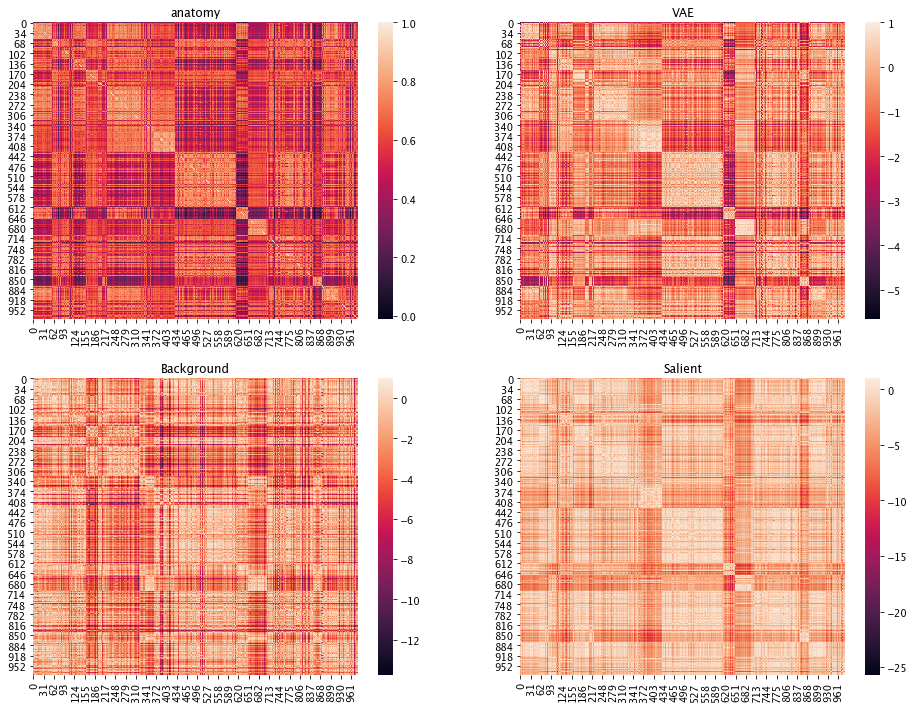

In [60]:
arrs = (np.corrcoef(arr),1-squareform(pdist(v)),1-squareform(pdist(z)),1-squareform(pdist(s)))
ttls = ['anatomy','VAE','Background','Salient']
plt.figure(figsize=(16,12))

#sord = np.argsort(dxArr)
#nsubs = arr.shape[0]

for i in range(4):
    plt.subplot(2,2,i+1)
    sns.heatmap(arrs[i])
    #plt.xticks(np.arange(nsubs)[1::50],labels=dxArr[sord][1::50])
    #plt.yticks(np.arange(nsubs)[1::50],labels=dxArr[sord][1::50])
    plt.title(ttls[i])

In [89]:
# plt.figure(figsize=np.array((12,8))*1.6)
# f = 612
# t = 682
# ofs = 10
# rng = np.arange(f-ofs,t+ofs)
# sns.heatmap(arrs[3][rng,:][:,rng])
# plt.xticks(range(len(rng)),labels=[int(i) for i in dxArr[rng]],fontsize=12);
# plt.yticks(range(len(rng)),labels=[int(i) for i in dxArr[rng]],fontsize=12);

### Get avg e dist between ASD and TD
### What is the 258 on the bottlenack

In [ ]:
# s_encoder.summary()

In [126]:
sample_brain = cvae_decoder.predict(np.random.randn(16,4))

In [100]:
recon = cvae.predict([TD_batch,DX_batch])[0]

In [90]:
import ants

In [93]:
fn = '/Users/aidasaglinskas/Downloads/sub-002_brain.nii'
im = ants.image_read(fn)
tinyIm = im.resample_image((64,64,64), use_voxels=True, interp_type=1)

In [109]:
ofdir = '/Users/aidasaglinskas/Desktop/play/'
ofn = 

(16, 64, 64, 64, 1)

In [122]:
# Generate CCVAE predictions for brain
for i in range(10):
    tinyIm.new_image_like(recon[i,:,:,:,0]).to_filename(os.path.join(ofdir,f'recon{i:02}.nii'))

In [125]:
# Reconstruct BRainzz
for i in range(10):
    tinyIm.new_image_like(TD_batch[i,:,:,:]).to_filename(os.path.join(ofdir,f'batch{i:02}.nii'))

In [128]:
# Generate random Brain
for i in range(10):
    tinyIm.new_image_like(sample_brain[i,:,:,:,0]).to_filename(os.path.join(ofdir,f'sampl{i:02}.nii'))

In [133]:
# Generate VAE predictions for brain
for i in range(10):
    tinyIm.new_image_like(vpred[i,:,:,:,0]).to_filename(os.path.join(ofdir,f'vrecon{i:02}.nii'))

In [139]:
# Generate VAE predictions for brain
for i in range(10):
    tinyIm.new_image_like(arr[i,:,:,:,0]).to_filename(os.path.join(ofdir,f'aa{i:02}.nii'))

In [135]:
arr = cvae_fg.predict(TD_batch)

In [138]:
arr[0,:,:,:,0]

array([[[2.05389188e-05, 4.36219096e-08, 1.14304450e-08, ...,
         1.61909384e-08, 4.84809739e-08, 6.58466888e-05],
        [5.43776025e-07, 9.54789858e-11, 3.18501931e-12, ...,
         3.77389439e-12, 3.04901959e-12, 2.37017986e-07],
        [3.22563693e-07, 7.43987944e-12, 6.65298640e-14, ...,
         9.70969283e-15, 1.49938435e-14, 1.51022395e-08],
        ...,
        [1.96624696e-11, 3.13785010e-18, 4.05808553e-22, ...,
         1.96608341e-17, 9.49854889e-18, 1.53308352e-10],
        [4.25492176e-11, 4.21156217e-19, 1.55494519e-23, ...,
         1.00491135e-20, 1.15427893e-20, 4.23023075e-12],
        [2.77220006e-05, 3.06782555e-09, 3.02752164e-11, ...,
         6.04286565e-10, 2.19245816e-10, 2.41136986e-05]],

       [[2.51964082e-07, 4.63509483e-12, 2.63168366e-13, ...,
         7.40096786e-13, 1.90573273e-12, 1.15761139e-07],
        [1.95518199e-10, 5.39981932e-18, 3.61839690e-20, ...,
         1.29456682e-20, 3.55684044e-20, 1.74828919e-11],
        [1.43847391e-11, 

In [134]:
cvae_fg.summary()

Model: "contrastive_vae_fg"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
tg_inputs (InputLayer)          [(None, 64, 64, 64,  0                                            
__________________________________________________________________________________________________
conv3d_6 (Conv3D)               (None, 32, 32, 32, 3 896         tg_inputs[0][0]                  
__________________________________________________________________________________________________
conv3d_7 (Conv3D)               (None, 16, 16, 16, 6 55360       conv3d_6[0][0]                   
__________________________________________________________________________________________________
flatten_4 (Flatten)             (None, 262144)       0           conv3d_7[0][0]                   
_________________________________________________________________________________